In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Параметры
image_size = (224, 224)
batch_size = 32
num_epochs = 15
learning_rate = 0.001
num_classes = 5  # квадрат, круг, овал, треугольник, прямоугольник
data_dir = "./shapes_dataset" 
os.makedirs(data_dir, exist_ok=True)

# Генерация данных
class ShapeGenerator:
    def __init__(self, image_size):
        self.image_size = image_size
        self.shapes = ['square', 'circle', 'oval', 'triangle', 'rectangle']
        
    def generate_shape(self, shape_idx, filled):
        img = Image.new('RGB', self.image_size, 'white')
        draw = ImageDraw.Draw(img)
        
        # Определяем границы для фигуры
        margin = 20 # отступ
        min_size = 30  # минимальный размер фигуры
        
        
        x1 = random.randint(margin, self.image_size[0] - margin - min_size - 1)
        y1 = random.randint(margin, self.image_size[1] - margin - min_size - 1)
        
        # Обеспечиваем минимальный размер фигуры
        x2 = random.randint(x1 + min_size, self.image_size[0] - margin - 1)
        y2 = random.randint(y1 + min_size, self.image_size[1] - margin - 1)
        
        fill = random.choice(['red', 'green', 'blue', 'yellow', 'black']) if filled else None
        
        if self.shapes[shape_idx] == 'square':
            side = min(x2 - x1, y2 - y1)
            shape = [(x1, y1), (x1 + side, y1 + side)]
            draw.rectangle(shape, outline='black', fill=fill)
        elif self.shapes[shape_idx] == 'circle':
            draw.ellipse([(x1, y1), (x2, y2)], outline='black', fill=fill)
        elif self.shapes[shape_idx] == 'oval':
            
            width = x2 - x1
            height = width // 2
            y2 = min(y1 + height, self.image_size[1] - margin - 1)
            draw.ellipse([(x1, y1), (x2, y2)], outline='black', fill=fill)
        elif self.shapes[shape_idx] == 'triangle':
            draw.polygon([(x1, y2), ((x1 + x2) // 2, y1), (x2, y2)], outline='black', fill=fill)
        elif self.shapes[shape_idx] == 'rectangle':
            
            width = x2 - x1
            height = width // 2
            y2 = min(y1 + height, self.image_size[1] - margin - 1)
            draw.rectangle([(x1, y1), (x2, y2)], outline='black', fill=fill)
        
        return img


In [14]:
# Создаем датасет
import random

def create_dataset(num_samples_per_class=500):
    generator = ShapeGenerator(image_size)
    images = []
    labels = []
    
    for shape_idx in range(num_classes):
        for _ in range(num_samples_per_class):
            filled = random.random() < 5 / 6  # False с вероятностью 1/6, True — 5/6
            img = generator.generate_shape(shape_idx, filled)
            images.append(img)
            labels.append(shape_idx)
    
    return images, labels

In [15]:
# Генерируем данные
images, labels = create_dataset(3000)

# Разделяем данные на train, val и test
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)


In [16]:
# Кастомный Dataset
class ShapeDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [17]:
# Аугментации
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
# Создаем DataLoader'ы
train_dataset = ShapeDataset(X_train, y_train, train_transform)
val_dataset = ShapeDataset(X_val, y_val, val_transform)
test_dataset = ShapeDataset(X_test, y_test, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
# Модель
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


In [20]:
# Обучение модели
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        
        # Валидация
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model


In [21]:
# Обучаем модель
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/15
Train Loss: 0.3329, Acc: 0.8527
Val Loss: 0.1467, Acc: 0.9342
Epoch 2/15
Train Loss: 0.1720, Acc: 0.9230
Val Loss: 0.2892, Acc: 0.8662
Epoch 3/15
Train Loss: 0.1768, Acc: 0.9256
Val Loss: 0.1106, Acc: 0.9458
Epoch 4/15
Train Loss: 0.1639, Acc: 0.9321
Val Loss: 0.1111, Acc: 0.9636
Epoch 5/15
Train Loss: 0.1336, Acc: 0.9410
Val Loss: 0.1264, Acc: 0.9404
Epoch 6/15
Train Loss: 0.1378, Acc: 0.9407
Val Loss: 0.0904, Acc: 0.9582
Epoch 7/15
Train Loss: 0.1162, Acc: 0.9478
Val Loss: 0.0833, Acc: 0.9631
Epoch 8/15
Train Loss: 0.1594, Acc: 0.9356
Val Loss: 0.0817, Acc: 0.9640
Epoch 9/15
Train Loss: 0.1228, Acc: 0.9480
Val Loss: 0.0823, Acc: 0.9733
Epoch 10/15
Train Loss: 0.1128, Acc: 0.9508
Val Loss: 0.0889, Acc: 0.9613
Epoch 11/15
Train Loss: 0.1200, Acc: 0.9487
Val Loss: 0.0809, Acc: 0.9631
Epoch 12/15
Train Loss: 0.1002, Acc: 0.9568
Val Loss: 0.1825, Acc: 0.8991
Epoch 13/15
Train Loss: 0.0944, Acc: 0.9590
Val Loss: 0.1128, Acc: 0.9520
Epoch 14/15
Train Loss: 0.1246, Acc: 0.9496
Val

In [22]:
# Тестирование
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Test Accuracy: {correct / total:.4f}')

In [23]:
# Загружаем лучшую модель и тестируем
best_model = resnet18(pretrained=False)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model = best_model.to(device)

test_model(best_model, test_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Accuracy: 0.9698


In [24]:
# Функция для предсказания на одном изображении
def predict_shape(image_path, model, transform):
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output.data, 1)
    
    shapes = ['square', 'circle', 'oval', 'triangle', 'rectangle']
    return shapes[predicted.item()]


Predicted shape: triangle


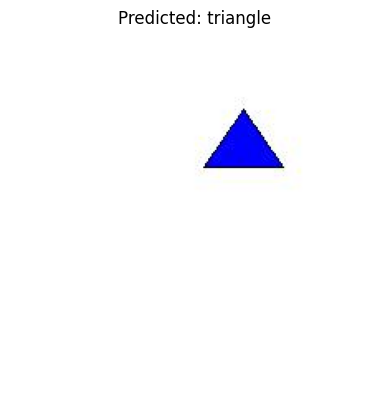

In [25]:
# Пример использования
test_img_path = "test_shape.jpg"
test_img = ShapeGenerator(image_size).generate_shape(random.randint(0, num_classes-1), random.choice([True, False]))
test_img.save(test_img_path)

predicted_shape = predict_shape(test_img_path, best_model, val_transform)
print(f"Predicted shape: {predicted_shape}")
plt.imshow(Image.open(test_img_path))
plt.title(f"Predicted: {predicted_shape}")
plt.axis('off')
plt.show()

Classification Report:
              precision    recall  f1-score   support

      square       1.00      1.00      1.00       450
      circle       0.89      0.87      0.88       450
        oval       0.88      0.89      0.88       450
    triangle       1.00      1.00      1.00       450
   rectangle       1.00      1.00      1.00       450

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      2250
weighted avg       0.95      0.95      0.95      2250



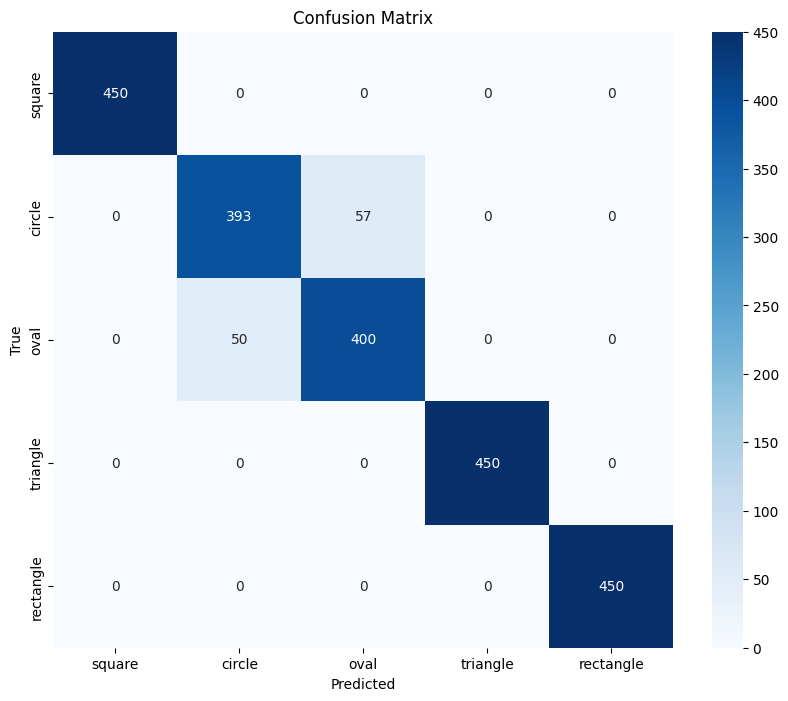


Accuracy per class:
square: 1.0000
circle: 0.8733
oval: 0.8889
triangle: 1.0000
rectangle: 1.0000

Overall accuracy: 0.9524


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

class_names = ['square', 'circle', 'oval', 'triangle', 'rectangle']

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Строим confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Рассчитываем точность для каждого класса
class_accuracy = {}
for i in range(len(class_names)):
    correct = cm[i,i]
    total = sum(cm[i,:])
    accuracy = correct / total
    class_accuracy[class_names[i]] = accuracy

print("\nAccuracy per class:")
for shape, acc in class_accuracy.items():
    print(f"{shape}: {acc:.4f}")

# Общая точность
total_accuracy = sum([cm[i,i] for i in range(len(class_names))]) / sum(sum(cm))
print(f"\nOverall accuracy: {total_accuracy:.4f}")